In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 as cv

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

In [2]:
DATAPATH = r"C:\Users\yuvfr\proj_university\swedish-leaf-classification\swedish-leaf-dataset"

In [3]:
IMG_SIZE = 224
LEAF_CLASSES = (1, 3)
leaf1, leaf2 = LEAF_CLASSES

In [4]:
def load_image(filename, height=IMG_SIZE, width=IMG_SIZE):
    img = cv.imread(filename, cv.IMREAD_COLOR)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (height, width))
    return img

In [5]:
def load_leaf_data(leaf, label):
    leaf_path = os.path.join(DATAPATH,f"leaf{leaf}")
    leaf_imgs_list = []

    for img_fname in os.listdir(leaf_path):
        leaf_imgs_list.append(load_image(os.path.join(leaf_path, img_fname)))
    
    data = np.stack(leaf_imgs_list)
    label_arr = np.repeat(label, len(leaf_imgs_list)).reshape(-1,1)
    return data, label_arr
    

In [6]:
data1, label1 = load_leaf_data(leaf1, 0)
data2, label2 = load_leaf_data(leaf2, 1)

In [7]:
TEST_SIZE = 0.15

In [8]:
[(data.shape, label.shape, label[0]) for data, label in [(data1, label1), (data2, label2)]]

[((75, 224, 224, 3), (75, 1), array([0])),
 ((75, 224, 224, 3), (75, 1), array([1]))]

In [9]:
# split data equally
splits = [train_test_split(
    data, label, test_size=TEST_SIZE, random_state=42) 
          for data, label in [(data1, label1), (data2, label2)]]
X_train, X_test, y_train, y_test = [np.vstack(phase) for phase in zip(*splits)]
[arr.shape for arr in [X_train, y_train, X_test, y_test]]

[(126, 224, 224, 3), (126, 1), (24, 224, 224, 3), (24, 1)]

# Justification for PCA

In [10]:
full_pca = PCA(n_components=len(X_train))
full_pca.fit(X_train.reshape(len(X_train),-1))

PCA(n_components=126)

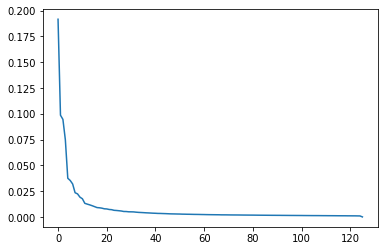

In [11]:
plt.plot(full_pca.explained_variance_ratio_)

# Model

In [12]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define a Transformer that flats the images
def flat_image(x):
    return x.reshape(len(x),-1)

def inverse_flat_image(x, height=IMG_SIZE, width=IMG_SIZE, channels=3):
    return x.reshape(len(x), height, width, channels)

flat_transformer = FunctionTransformer(flat_image, inverse_flat_image)

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

log_reg = LogisticRegression(random_state=42)

pipe = Pipeline(steps=[("flat", flat_transformer), 
                       ("scaler", scaler), 
                       ("pca", pca), 
                       ("log_reg", log_reg)
                      ])

K_FOLDS = 6
param_grid = {
    "pca__n_components": np.ceil(np.logspace(
        start=2, stop=np.log2(len(X_train) * (K_FOLDS-1)/K_FOLDS * .75), base=2, num=3)).astype(int),
    "log_reg__C": np.logspace(start=-5, stop=1, base=10, num=3),
}

search = GridSearchCV(pipe, param_grid, cv=K_FOLDS, verbose=3) # scoring="accuracy"
search

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('flat',
                                        FunctionTransformer(func=<function flat_image at 0x0000029C1DD8E940>,
                                                            inverse_func=<function inverse_flat_image at 0x0000029C1B1B4040>)),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('log_reg', LogisticRegression())]),
             param_grid={'log_reg__C': array([1.e-05, 1.e-02, 1.e+01]),
                         'pca__n_components': array([ 4, 18, 79])},
             verbose=3)

In [13]:
search.fit(X_train, y_train.reshape(-1,))
print(f"Best Hyperparameters: {search.best_params_}")
print(f"Best CV Accuracy: {search.best_score_:.4f}")

Fitting 6 folds for each of 9 candidates, totalling 54 fits
[CV 1/6] END log_reg__C=1e-05, pca__n_components=4;, score=0.810 total time=   2.5s
[CV 2/6] END log_reg__C=1e-05, pca__n_components=4;, score=0.762 total time=   2.8s
[CV 3/6] END log_reg__C=1e-05, pca__n_components=4;, score=0.762 total time=   3.0s
[CV 4/6] END log_reg__C=1e-05, pca__n_components=4;, score=0.810 total time=   2.5s
[CV 5/6] END log_reg__C=1e-05, pca__n_components=4;, score=0.810 total time=   2.3s
[CV 6/6] END log_reg__C=1e-05, pca__n_components=4;, score=0.810 total time=   2.2s
[CV 1/6] END log_reg__C=1e-05, pca__n_components=18;, score=0.762 total time=   2.9s
[CV 2/6] END log_reg__C=1e-05, pca__n_components=18;, score=0.905 total time=   2.5s
[CV 3/6] END log_reg__C=1e-05, pca__n_components=18;, score=0.714 total time=   2.6s
[CV 4/6] END log_reg__C=1e-05, pca__n_components=18;, score=0.952 total time=   2.5s
[CV 5/6] END log_reg__C=1e-05, pca__n_components=18;, score=1.000 total time=   2.9s
[CV 6/6] EN

c:\users\yuvfr\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/6] END log_reg__C=0.01, pca__n_components=18;, score=0.810 total time=   2.8s
[CV 1/6] END log_reg__C=0.01, pca__n_components=79;, score=0.810 total time=   7.2s
[CV 2/6] END log_reg__C=0.01, pca__n_components=79;, score=0.762 total time=   8.8s
[CV 3/6] END log_reg__C=0.01, pca__n_components=79;, score=0.905 total time=   7.5s
[CV 4/6] END log_reg__C=0.01, pca__n_components=79;, score=0.857 total time=   6.9s
[CV 5/6] END log_reg__C=0.01, pca__n_components=79;, score=0.952 total time=   6.7s
[CV 6/6] END log_reg__C=0.01, pca__n_components=79;, score=0.762 total time=   6.6s
[CV 1/6] END log_reg__C=10.0, pca__n_components=4;, score=0.810 total time=   2.0s
[CV 2/6] END log_reg__C=10.0, pca__n_components=4;, score=0.762 total time=   1.9s
[CV 3/6] END log_reg__C=10.0, pca__n_components=4;, score=0.714 total time=   1.8s
[CV 4/6] END log_reg__C=10.0, pca__n_components=4;, score=0.810 total time=   1.8s
[CV 5/6] END log_reg__C=10.0, pca__n_components=4;, score=0.857 total time=   1.

c:\users\yuvfr\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/6] END log_reg__C=10.0, pca__n_components=18;, score=0.952 total time=   2.1s
[CV 3/6] END log_reg__C=10.0, pca__n_components=18;, score=0.762 total time=   2.2s


c:\users\yuvfr\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/6] END log_reg__C=10.0, pca__n_components=18;, score=0.857 total time=   2.5s


c:\users\yuvfr\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/6] END log_reg__C=10.0, pca__n_components=18;, score=0.952 total time=   2.6s


c:\users\yuvfr\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/6] END log_reg__C=10.0, pca__n_components=18;, score=0.810 total time=   2.7s
[CV 1/6] END log_reg__C=10.0, pca__n_components=79;, score=0.810 total time=   8.5s
[CV 2/6] END log_reg__C=10.0, pca__n_components=79;, score=0.857 total time=   8.7s


c:\users\yuvfr\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/6] END log_reg__C=10.0, pca__n_components=79;, score=0.905 total time=  10.4s


c:\users\yuvfr\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/6] END log_reg__C=10.0, pca__n_components=79;, score=0.905 total time=  11.1s
[CV 5/6] END log_reg__C=10.0, pca__n_components=79;, score=0.952 total time=   8.2s
[CV 6/6] END log_reg__C=10.0, pca__n_components=79;, score=0.762 total time=   8.1s
Best Hyperparameters: {'log_reg__C': 0.01, 'pca__n_components': 18}
Best CV Accuracy: 0.8730


In [14]:
from sklearn.metrics import classification_report

def evaluate(model, X, y, title):
    preds = model.predict(X).reshape(-1,1)
    print(title,'\n',classification_report(y, preds))

In [15]:
evaluate(search, X_train, y_train, "train")
evaluate(search, X_test, y_test, "test")

train 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98        63
           1       0.97      0.98      0.98        63

    accuracy                           0.98       126
   macro avg       0.98      0.98      0.98       126
weighted avg       0.98      0.98      0.98       126

test 
               precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.79      0.92      0.85        12

    accuracy                           0.83        24
   macro avg       0.84      0.83      0.83        24
weighted avg       0.84      0.83      0.83        24



In [17]:
import wandb

wandb.init(project="swedish-leaf-classification", group="baseline",
           entity="yuvfried", job_type="notebook", name="baseline_1_3",
           resume="allow", mode="online")

preds = search.predict(X_test).reshape(-1,1)
test_acc = np.mean(y_test == preds)
print(f"Test Accuracy: {test_acc:.4f}")

wandb.log({"test_acc":test_acc})
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yuvfried (use `wandb login --relogin` to force relogin)


Test Accuracy: 0.8333


test_acc,▁
test_acc,0.83333
